In [151]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/GitHub/dynamics-simulation-16-715/lecture-notebooks/Lecture 16/Project.toml`


In [152]:
using LinearAlgebra
using OrdinaryDiffEq
using ForwardDiff
using Plots

In [153]:
#Pendulum Parameters
ℓ = 1.0
m = 1.0
g = 9.81

9.81

In [154]:
#Reference solution with Baumgarte stabilization
function f(x,p,t)
    q = x[1:2]
    v = x[3:4]
    
    α = 10.0
    β = 3.0
    
    M = m*I(2)
    G = [0.0; m*g]
    J = dcdq(q)
    
    c = constraint(q)
    ċ = J*v
    d = 2*v'*v
    e = J*(M\(J'*(α*c + β*ċ)))
    
    z = [M J'; J 0]\[-G; -(d+e)]
    
    v̇ = z[1:2]
    
    ẋ = [v; v̇]
end

function constraint(q)
    return q[1]^2 + q[2]^2 - ℓ^2
end

function dcdq(q)
    return [2*q[1]; 2*q[2]]'
end

dcdq (generic function with 1 method)

In [155]:
#initial conditions
q0 = [1.0; 0]
x0 = [q0; 0; 0]

4-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0

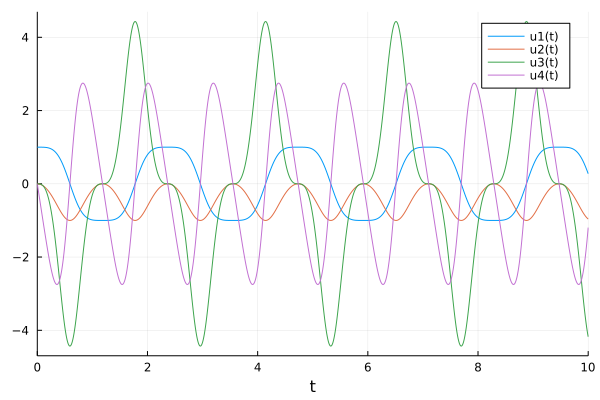

In [156]:
#Simulate
tspan = (0.0,10.0)
prob = ODEProblem(f,x0,tspan)
#sol = solve(prob,Tsit5());
sol = solve(prob,Tsit5(),abstol=1e-6,reltol=1e-6);
plot(sol)

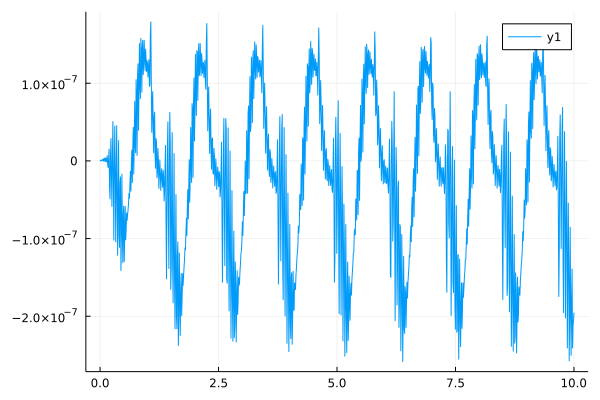

In [161]:
#Calculate constraint violation
N = 1000
t = LinRange(tspan[1],tspan[2],N)
c_error = zeros(N)
for k = 1:N
    c_error[k] = constraint(sol(t[k])[1:2])
end

plot(t,c_error)

In [163]:
h = 0.05
t = 0:h:10.0

function T(q,q̇)
    0.5*m*q̇'*q̇
end

function U(q)
    m*g*q[2]
end

function L(q,q̇)
    return T(q,q̇) - U(q)
end

function Ld(q1,q2)
    qm = 0.5*(q1+q2)
    q̇m = (q2-q1)/h
    return h*L(qm,q̇m)
end

function DEL(q1,q2,q3,λ)
    ForwardDiff.gradient(dq2->Ld(q1,dq2),q2) + ForwardDiff.gradient(dq2->Ld(dq2,q3),q2) + h*λ*dcdq(q2)'
end

DEL (generic function with 2 methods)

In [164]:
qhist = zeros(2,length(t))
qhist[:,1] .= q1
qhist[:,2] .= q2

for k = 2:(length(t)-1)
    #Initial guess for Newton
    qhist[:,k+1] .= qhist[:,k]
    λ = 0.0
    
    #KKT residual
    r = [DEL(qhist[:,k-1],qhist[:,k],qhist[:,k+1],λ); constraint(qhist[:,k+1])]
    
    #Newton's method
    while maximum(abs.(r)) > 1e-12
        drdq3 = ForwardDiff.jacobian(dq3->DEL(qhist[:,k-1],qhist[:,k],dq3,λ),qhist[:,k+1])
        drdλ = ForwardDiff.derivative(dλ->DEL(qhist[:,k-1],qhist[:,k],qhist[:,k+1],dλ),λ)
        
        Δ = -[drdq3 drdλ; dcdq(qhist[:,k+1]) 0]\r
        qhist[:,k+1] .= qhist[:,k+1] + Δ[1:2]
        λ = λ + Δ[3]
        r = [DEL(qhist[:,k-1],qhist[:,k],qhist[:,k+1],λ); constraint(qhist[:,k+1])]
    end
end

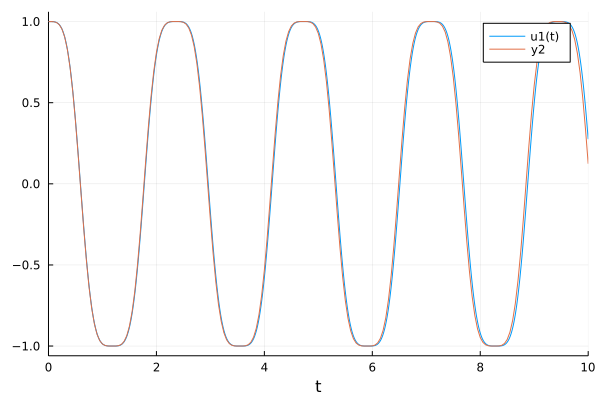

In [165]:
plot(sol,vars=(0,1))
plot!(t,qhist[1,:])

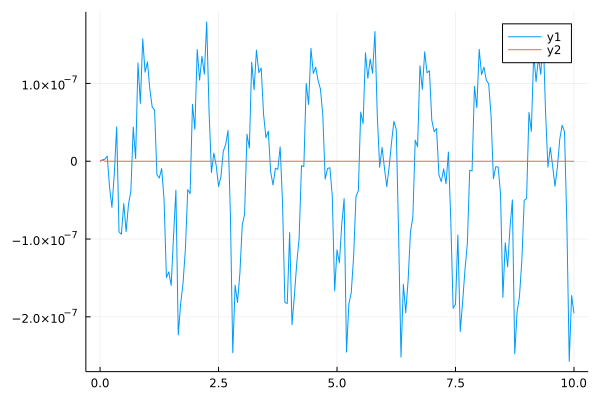

In [166]:
#Calculate constraint violation
N = length(t)
c_error1 = zeros(N)
c_error2 = zeros(N)
for k = 1:N
    c_error1[k] = constraint(sol(t[k])[1:2])
    c_error2[k] = constraint(qhist[:,k])
end

plot(t,c_error1)
plot!(t,c_error2)